In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

%cd "/content/drive/My Drive/CONSEGNA_ML"


# Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import torch
from models import DeepLabV3Lite, CNN_7_Layers
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from utils import ImageSegmentationDatasetOneHotEncoding, ImageSegmentationDatasetLogit, show_images_batch, color_map

## Load

In [ ]:
def load_model_from_checkpoint():
    model = DeepLabV3Lite().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    checkpoint = torch.load('checkpoint_epoch_15.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()  # set model to evaluation mode
    #start_epoch = checkpoint['epoch'] + 1
    return model

def load_model():
  model_instance = DeepLabV3Lite().to(device)
  model_instance.load_state_dict(torch.load('segmentation_model_epoch_10.pth', map_location='cpu'))
  model_instance.eval()  # set model to evaluation mode
  return model_instance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = load_model_from_checkpoint()

train_dir = 'train/' # Colab
# train_dir = '../../datasets/esame_ml/train'

dataset = ImageSegmentationDatasetOneHotEncoding(root_dir=train_dir) # ImageSegmentationDatasetLogit to change if model without onehotencoding
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Test

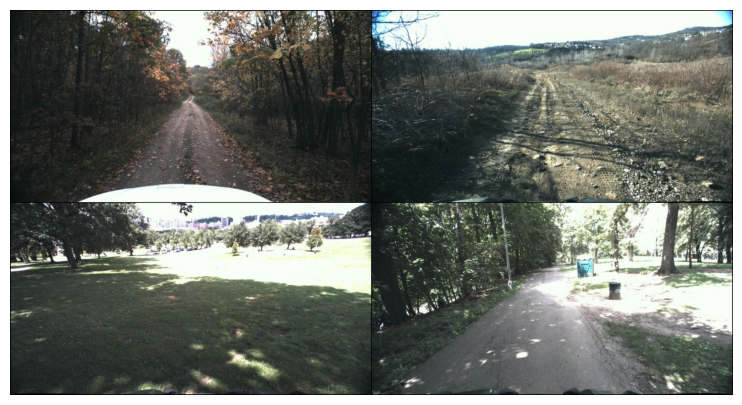

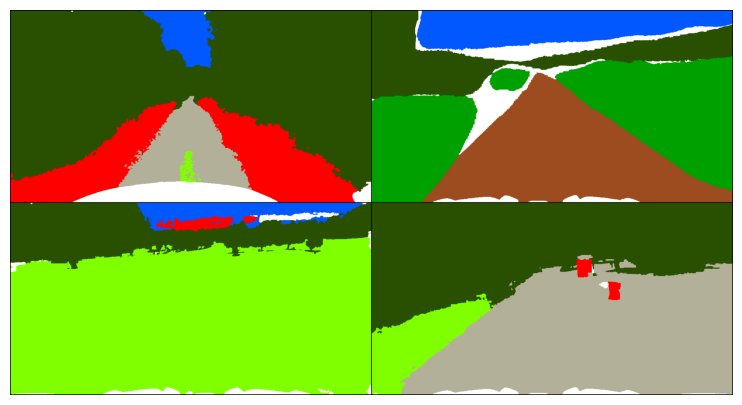

torch.Size([4, 3, 544, 1024])
torch.Size([4, 3, 544, 1024])


In [ ]:
# Show comparisons for first batch in batches
for images, labels, onehotencoding in dataloader:
    show_images_batch(images)
    show_images_batch(labels)
    print(images.shape)
    print(labels.shape)
    print(onehotencoding.shape)
    break

## After training

In [ ]:
def convert_prediction_to_rgb(pred, color_map):
    class_map = pred.argmax(dim=0).cpu().numpy()  # (H, W)
    inverse_color_map = {v: k for k, v in color_map.items()}
    h, w = class_map.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in inverse_color_map.items():
        rgb[class_map == class_idx] = color
    return rgb

In [ ]:
def visualize_sample_prediction(model, rgb_path, label_path, color_map, device):
    # Load images
    rgb_image = Image.open(rgb_path).convert("RGB")
    label_image = Image.open(label_path).convert("RGB")

    # Transform input image to tensor
    transform = T.Compose([
        T.ToTensor(),  # scales to [0, 1]
    ])
    image_tensor = transform(rgb_image).unsqueeze(0).to(device)  # (1, 3, H, W)

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image_tensor)  # (1, 9, H, W)
        output = output.squeeze(0).softmax(dim=0)  # (9, H, W)

    # Convert to RGB for visualization
    pred_rgb = convert_prediction_to_rgb(output, color_map)

    # Plot all
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(rgb_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(label_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Model Prediction")
    plt.imshow(pred_rgb)
    plt.axis("off")

    plt.show()


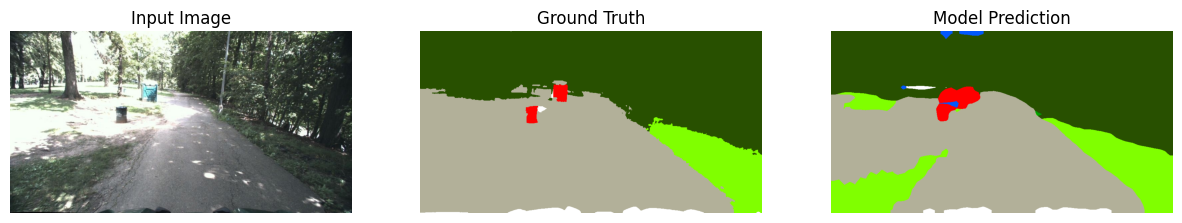

In [ ]:
#test_dir = 'train/'
test_dir = '../../datasets/esame_ml/train' #"./train"

sample_dir = os.path.join(test_dir, "0001")  # change to any valid sample
rgb_path = os.path.join(sample_dir, "rgb.jpg")
label_path = os.path.join(sample_dir, "labels.png")

visualize_sample_prediction(model, rgb_path, label_path, color_map, device)

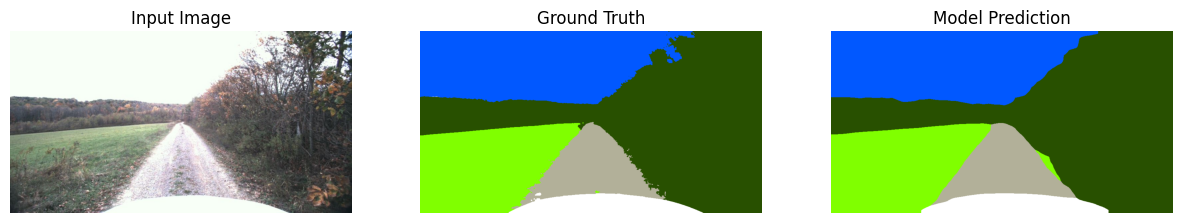

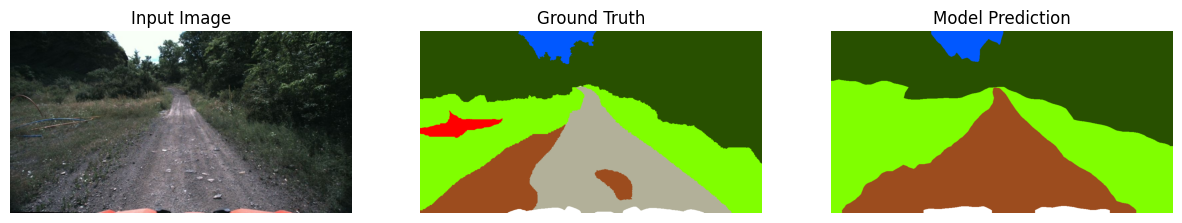

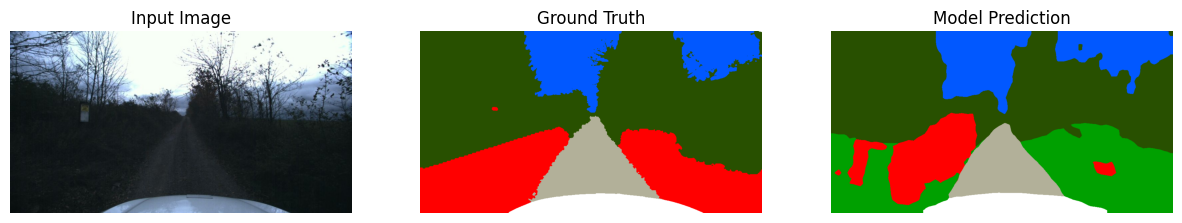

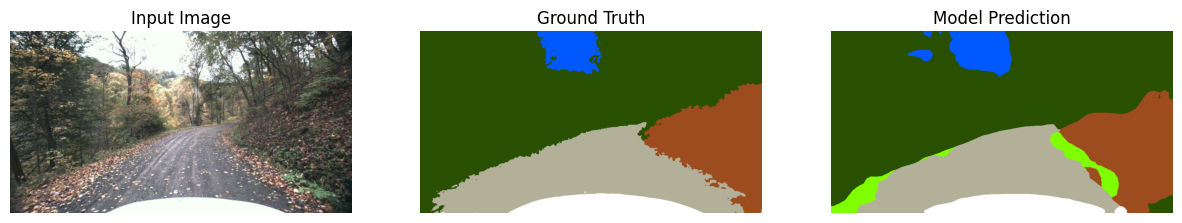

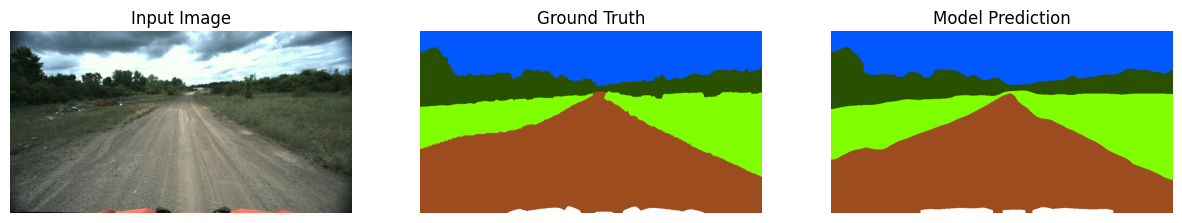

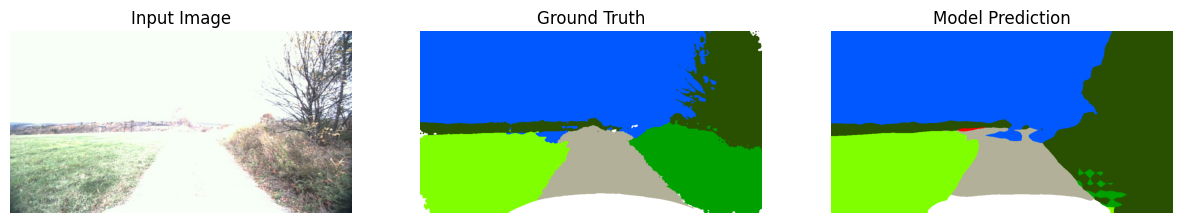

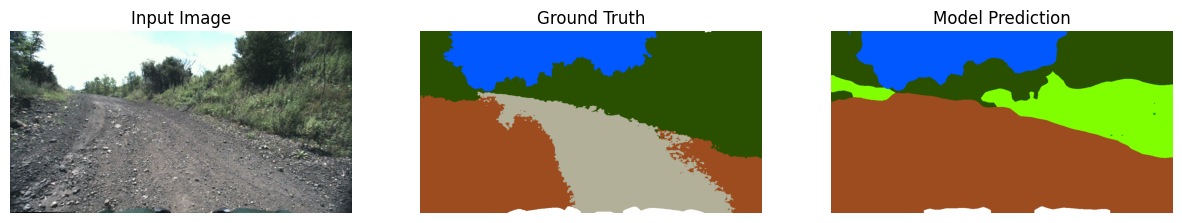

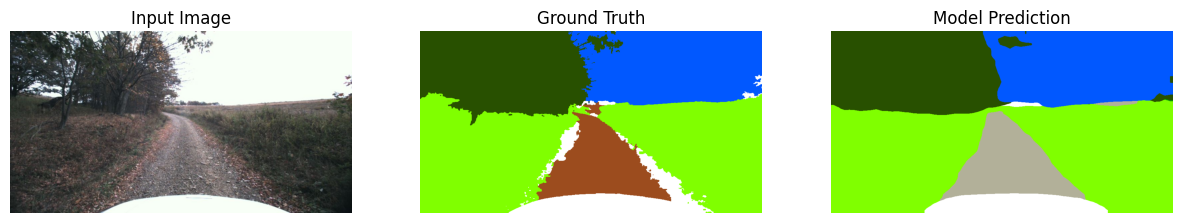

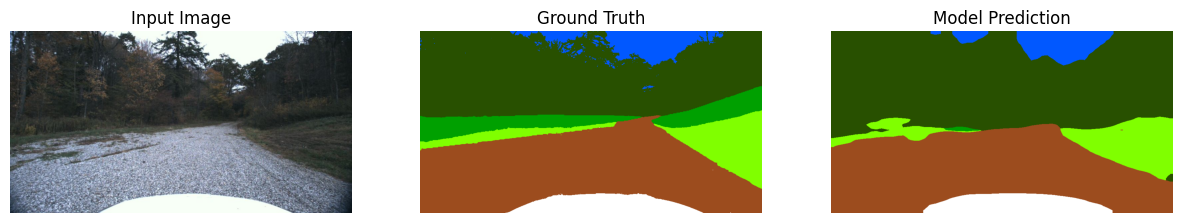

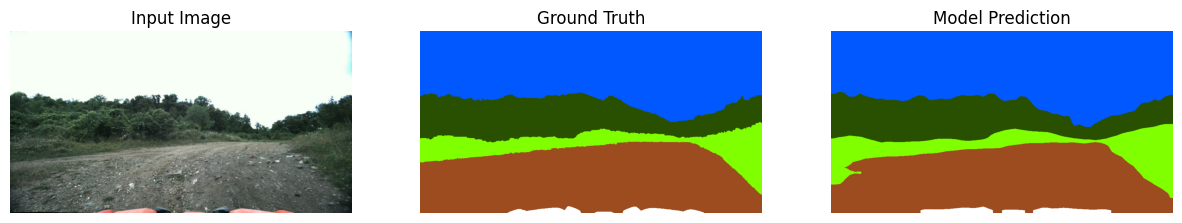

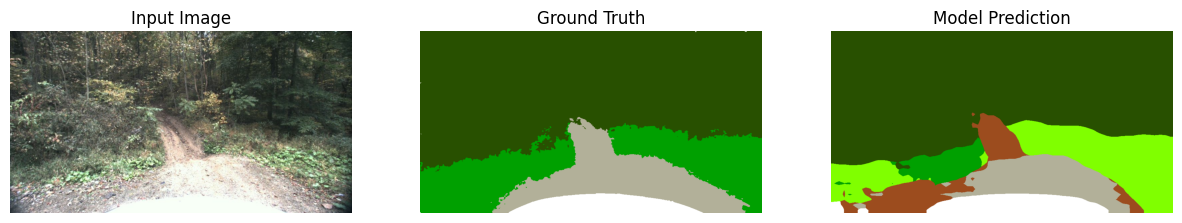

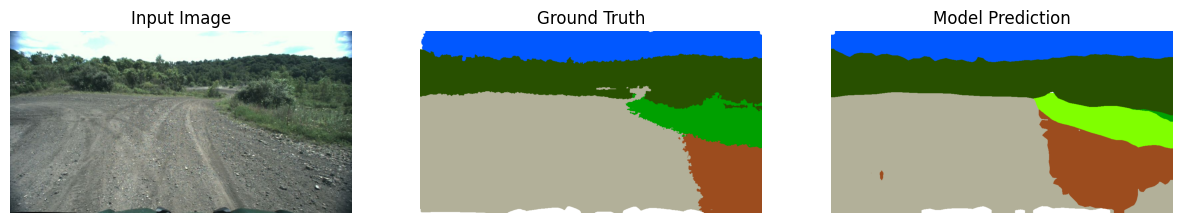

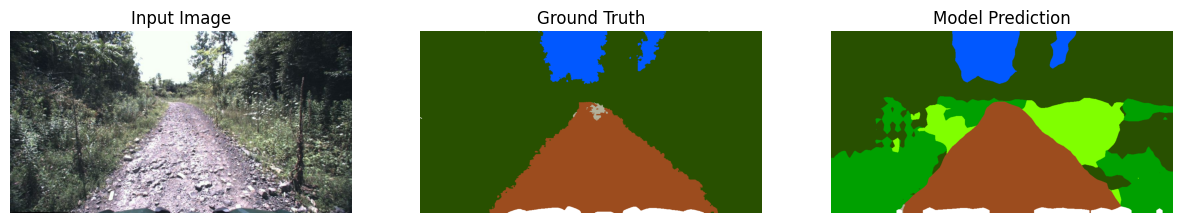

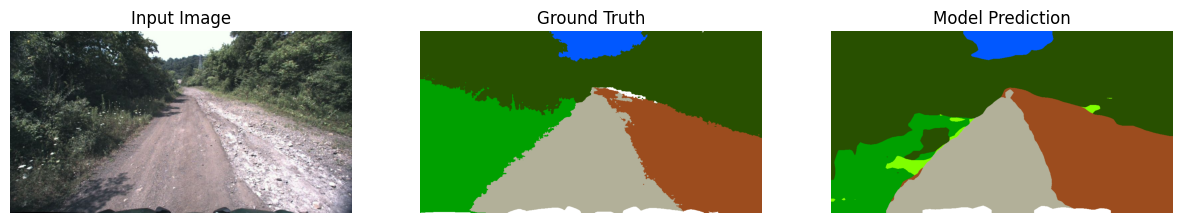

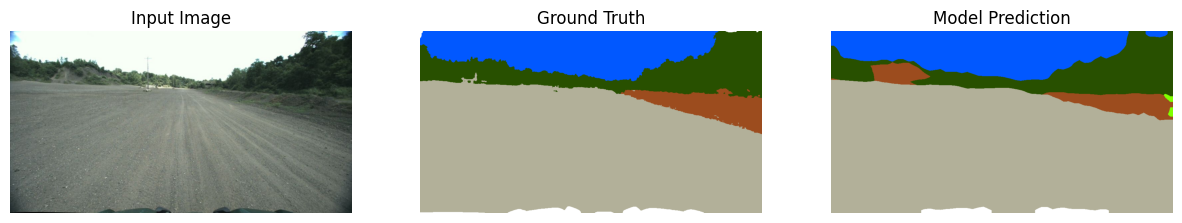

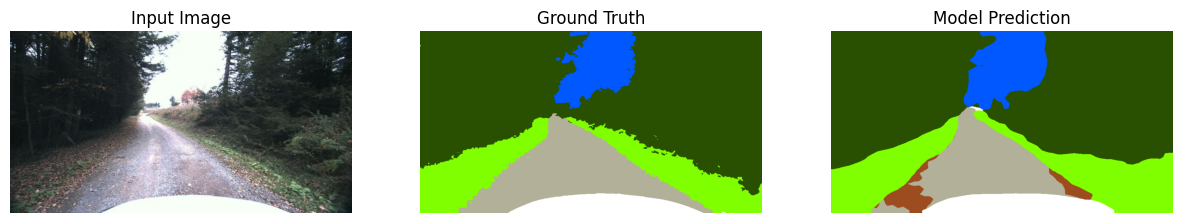

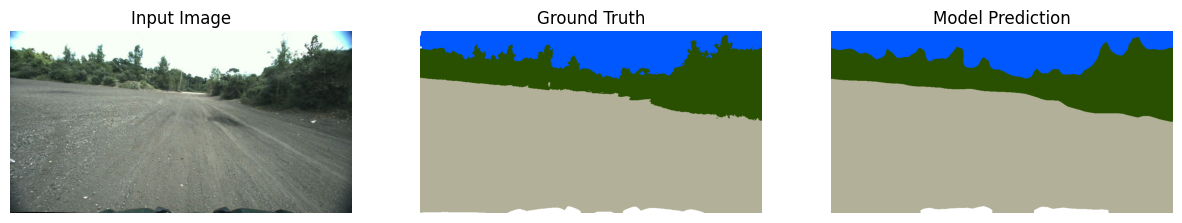

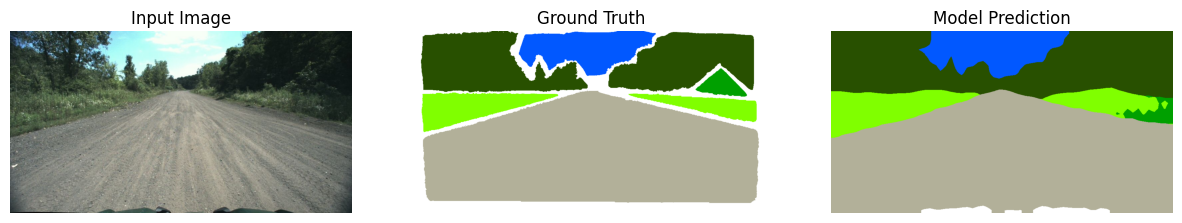

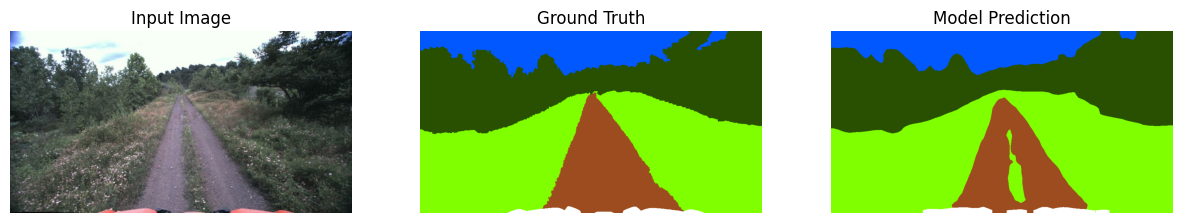

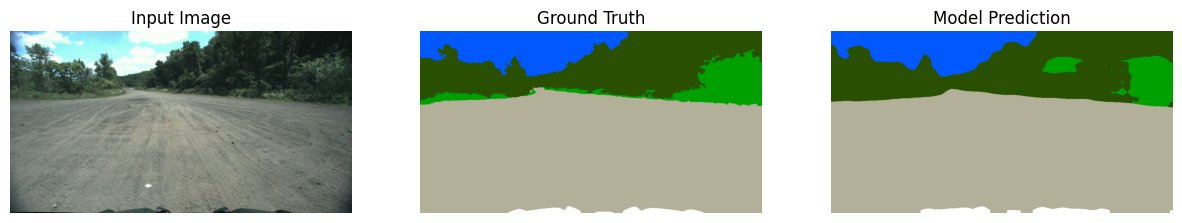

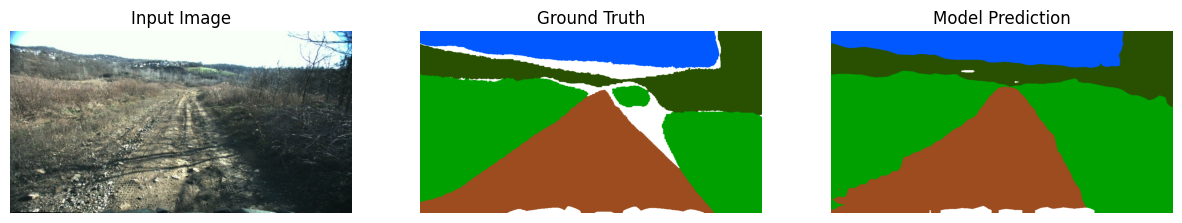

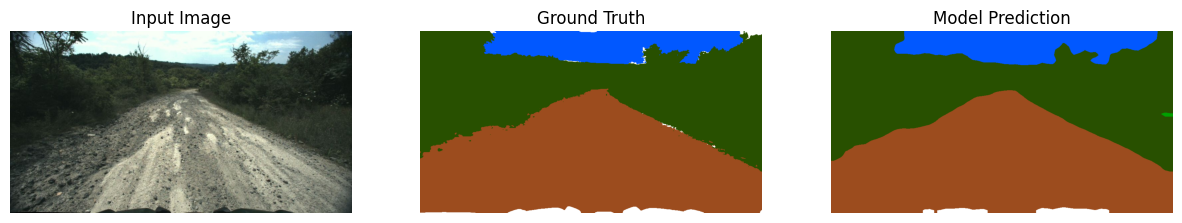

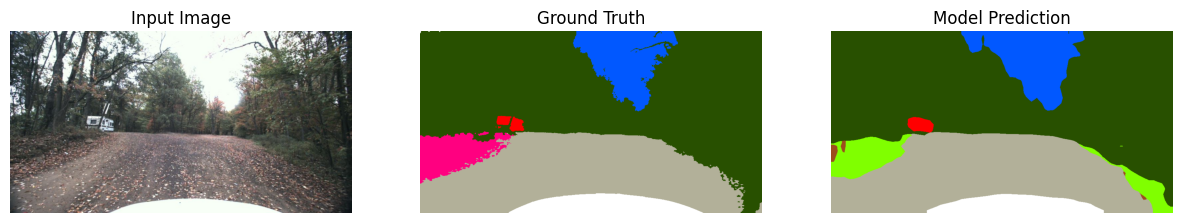

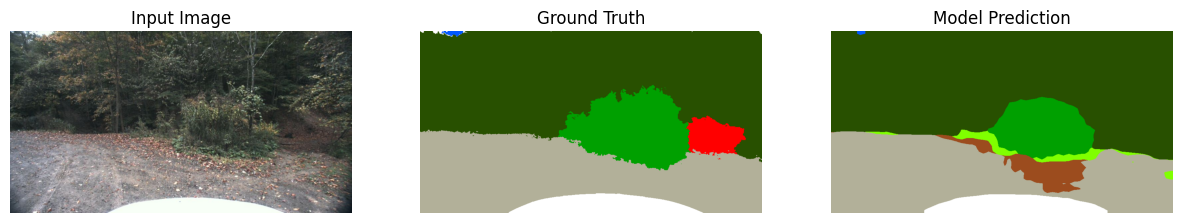

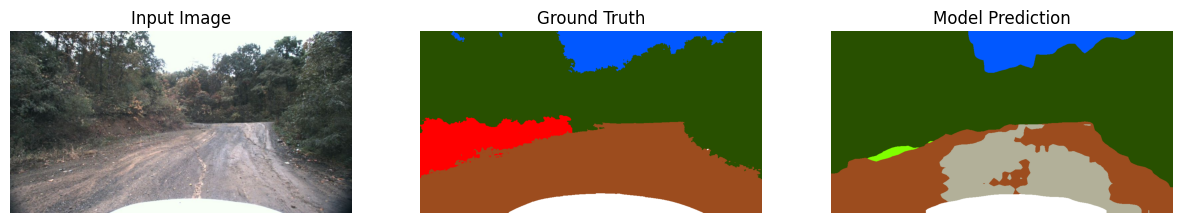

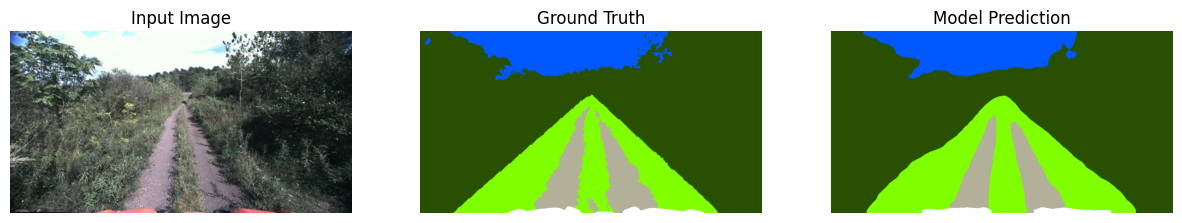

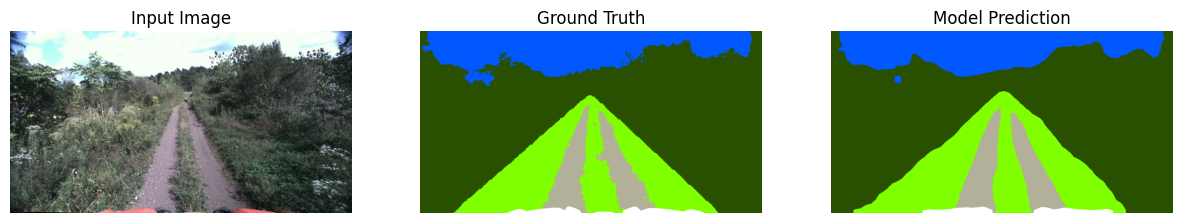

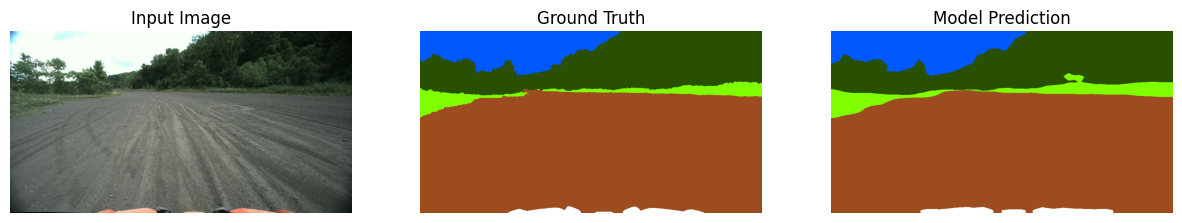

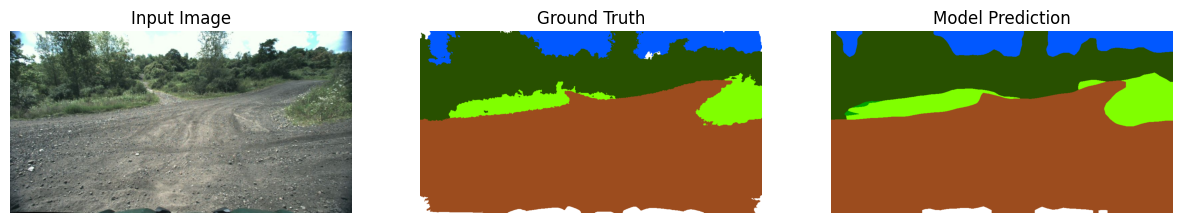

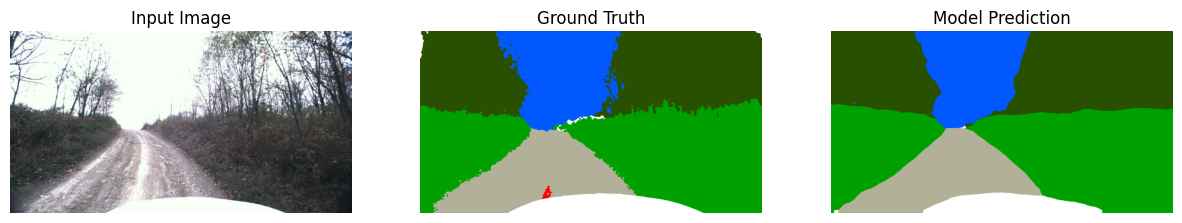

In [ ]:
samples = os.listdir(test_dir)

for subdir in samples[:30]:  # first 5 samples
    subdir_path = os.path.join(test_dir, subdir)
    rgb_path = os.path.join(subdir_path, 'rgb.jpg')
    label_path = os.path.join(subdir_path, 'labels.png')
    if os.path.exists(rgb_path) and os.path.exists(label_path):
        visualize_sample_prediction(model, rgb_path, label_path, color_map, device)
